# 1. Initialization

## Importing Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, AdamW, SGD, RMSprop, Adadelta
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics
import seaborn as sns
import pickle
from tqdm.notebook import tqdm

## Primary Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Path = "/content/drive/MyDrive/Thesis_Secondary"
Path1 = "/content/drive/MyDrive/Thesis_Preliminary"
Path2 = "/content/drive/MyDrive/Thesis/CNN-LSTM-Smoothed"


from google.colab import output
output.enable_custom_widget_manager()

Mounted at /content/drive


## Required Functions and Classes


In [ ]:
def train_val_test(Data_Frame, Val_Ratio, Test_Ratio, Seq_Length):

    train_ratio = 1 - (Val_Ratio + Test_Ratio)
    trainval_ratio = 1 - Test_Ratio
    data_size = len(Data_Frame)

    separator_1 = np.floor(data_size * train_ratio).astype(int)
    separator_2 = np.floor(data_size * trainval_ratio).astype(int)

    train = Data_Frame[:separator_1]
    validation = Data_Frame[separator_1 - Seq_Length + 1:separator_2]
    train_val = Data_Frame[:separator_2]
    test = Data_Frame[separator_2 - Seq_Length + 1:]

    return train, validation, train_val, test

# ---------------------------------------------------------------------------- #

def df_scaler(Data_Frame, Scaler):
    new_df = pd.DataFrame(
        Scaler.transform(Data_Frame),
        columns = Data_Frame.columns
    )
    return new_df

# ---------------------------------------------------------------------------- #

def Sequence_Maker(Input: pd.DataFrame, Target_Labels, Seq_Length):
    sequences = []
    input_size = len(Input)

    for i in range(input_size - Seq_Length):
        sequence = Input.iloc[i:i+Seq_Length]
        label_index = i + Seq_Length
        labels = Input.loc[label_index, Target_Labels]

        sequences.append((sequence, labels))

    return sequences

# ---------------------------------------------------------------------------- #

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

# ---------------------------------------------------------------------------- #

def Save(Input, File_Name, Type, Dir=Path):
    # print(Dir)
    full_name = f"{File_Name}.{Type}"

    if Type == "npy":
        np.save(full_name, Input)
        !cp "{full_name}" "{Dir}"

    elif Type == "csv":
        Input.to_csv(full_name)
        !cp "{full_name}" "{Dir}"
    
    elif Type == "xlsx":
        Input.to_excel(full_name)
        !cp "{full_name}" "{Dir}"
    
    elif Type == "pkl":
        pickle.dump(Input, open(full_name, 'wb'))
        !cp "{full_name}" "{Dir}"

    else:
        print("ERROR: Something goes wrong! Check the storage type.")

# ---------------------------------------------------------------------------- #

def Load(File_Name, Type, Dir=Path):
    # print(Dir)
    full_name = f"{File_Name}.{Type}"

    if Type == "npy":
        path = f"{Dir}/{full_name}"
        return np.load(path)
    
    elif Type == "xlsx":
        path = f"{Dir}/{full_name}"
        return pd.read_excel(path).drop(["Unnamed: 0"], axis=1)
    
    elif Type == "csv":
        path = f"{Dir}/{full_name}"
        return pd.read_csv(path).drop(["Unnamed: 0"], axis=1)
    
    elif Type == "pkl":
        path = f"{Dir}/{full_name}"
        return pickle.load(open(path, 'rb'))
    
    else:
        print("ERROR: Something goes wrong! Check the file's format.")

# ---------------------------------------------------------------------------- #

def Grids(Sequence_Lengths, Num_Filters, Conv1_Kernel_Size, Num_LSTM_Layers, Num_LSTM_Hiddens, Batch_Sizes):
    
    HyperParametersList = []
    combination_number = 0

    for b in range(len(Sequence_Lengths)):
        for c in range(len(Num_Filters)):
            for d in range(len(Conv1_Kernel_Size)):
                for j in range(len(Num_LSTM_Layers)):
                    for k in range(len(Num_LSTM_Hiddens)):
                        for l in range(len(Batch_Sizes)):

                            HP = {
                                'number' : combination_number,
                                'sequence_length' : Sequence_Lengths[b],
                                'num_filters' : Num_Filters[c],
                                'conv1_kernel_size' : Conv1_Kernel_Size[d],
                                'num_lstm_layers' : Num_LSTM_Layers[j],
                                'num_lstm_hiddens' : Num_LSTM_Hiddens[k],
                                'batch_sizes' : Batch_Sizes[l],
                            }

                            HyperParametersList.append(HP)
                            combination_number += 1
    
    return HyperParametersList

# ---------------------------------------------------------------------------- #

def Evaluate(labels, predictions):
    RMSE = metrics.mean_squared_error(y_true=labels, y_pred=predictions, squared=False)
    R2 = metrics.r2_score(y_true=labels, y_pred=predictions)
    MAE = metrics.mean_absolute_error(y_true=labels, y_pred=predictions)
    MAPE = metrics.mean_absolute_percentage_error(y_true=labels, y_pred=predictions)

    print("---------- Evaluation Results ----------\n")
    print(f"RMSE is:   {RMSE:.3f}")
    print(f"MAE is:   {MAE:.3f}")
    print(f"MAPE is:   {MAPE:.3f}")
    print(f"R-squared is:   {R2:.3f}")

# ---------------------------------------------------------------------------- #

def AR2(Num_Features, Num_Rows, labels, predictions):
    R2 = metrics.r2_score(y_true=labels, y_pred=predictions)
    AR2 = 1 - ((1 - R2) * (Num_Rows - 1) / (Num_Rows - Num_Features - 1))
    
    print(f"Adjusted R-squared is:   {AR2:.3f}")

# ---------------------------------------------------------------------------- #

class Dataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy().transpose()),
            label = torch.tensor(label).float()
        )

# ---------------------------------------------------------------------------- #

def Return_Column_Position(DF, Col_Name):
    p = -1
    for i in range(len(DF.columns)):
        if DF.columns[i] == Col_Name:
            p = i
    
    if p != -1:
        return p
    else:
        print(f"There is no {Col_Name} in the DataFrame columns!")

# ---------------------------------------------------------------------------- #

def Random_Sample(Set, Num):
    Length = len(Set)
    Sample_Indices = []
    while len(Sample_Indices) < Num:
        Random_Int = np.random.randint(0, Length)
        if Random_Int not in Sample_Indices:
            Sample_Indices.append(Random_Int)
    Sample_Array = np.array(Sample_Indices)
    return Sample_Indices

# ---------------------------------------------------------------------------- #

def Train_Val_Test_Index_Maker(Start, Stop, Train_Size, Val_Size, Test_Size):
    Train_Indices = Random_Sample(np.arange(Start, Stop), Train_Size)
    Val_Indices = []
    Test_Indices = []
    while len(Val_Indices) != Val_Size:
        Random_Int1 = np.random.randint(Start, Stop)
        if (Random_Int1 not in Train_Indices) and (Random_Int1 not in Val_Indices):
            Val_Indices.append(Random_Int1)
    while len(Test_Indices) != Test_Size:
        Random_Int2 = np.random.randint(Start, Stop)
        if (Random_Int2 not in Train_Indices) and (Random_Int2 not in Val_Indices) and (Random_Int2 not in Test_Indices):
            Test_Indices.append(Random_Int2)
    Train_Indices = np.array(Train_Indices)
    Val_Indices = np.array(Val_Indices)
    Test_Indices = np.array(Test_Indices)
    return Train_Indices, Val_Indices, Test_Indices

# ---------------------------------------------------------------------------- #


In [ ]:
def Top_N(Dict, Comb_Loss, N):
    Comb_Loss_Argsorted = np.argsort(Comb_Loss)
    new_dic = []
    for i in range(N):
        new_dic.append(Dict[Comb_Loss_Argsorted[i]])
    return new_dic

In [ ]:
# ---------------------------------------------------------------------------- #

class Hybrid_Model(nn.Module):

    def __init__(self, num_features, num_filters, conv1_kernel_size, conv1_stride, conv1_padding, maxpool1_kernel_size, maxpool1_stride,
                 maxpool1_padding, num_lstm_layers=2, num_lstm_hiddens=32, num_output=1):
        super(Hybrid_Model, self).__init__()
        
        self.num_features = num_features
        self.num_filters = num_filters
        self.conv1_kernel_size = conv1_kernel_size
        self.conv1_stride = conv1_stride
        self.conv1_padding = conv1_padding
        self.maxpool1_kernel_size = maxpool1_kernel_size
        self.maxpool1_stride = maxpool1_stride
        self.maxpool1_padding = maxpool1_padding
        self.num_lstm_layers = num_lstm_layers
        self.num_lstm_hiddens = num_lstm_hiddens
        self.num_output = num_output

        self.conv1 = nn.Conv1d(
            in_channels = num_features,
            out_channels = num_filters,
            kernel_size = conv1_kernel_size,
            stride = conv1_stride,
            padding = conv1_padding
        )
        
        self.lstm = nn.LSTM(
            input_size = num_filters,
            hidden_size = num_lstm_hiddens,
            num_layers = num_lstm_layers,
            batch_first = True,
            dropout = 0.2
        )

        self.fc = nn.Linear(num_lstm_hiddens, num_output)
    
    def forward(self, tensor):
        
        # (1) input layer
        t = tensor

        # (2) hidden convolutional layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool1d(t, kernel_size = self.maxpool1_kernel_size, stride = self.maxpool1_stride, padding = self.maxpool1_padding)
        
        # (3) hidden lstm layer
        self.lstm.flatten_parameters()
        h0 = torch.zeros(self.num_lstm_layers, t.size(0), self.num_lstm_hiddens)
        c0 = torch.zeros(self.num_lstm_layers, t.size(0), self.num_lstm_hiddens)
        _, (hidden, _) = self.lstm(t.transpose(1, 2), (h0, c0))
        out = hidden[-1]
        out = self.fc(out)

        return out.squeeze(dim=1)

# ---------------------------------------------------------------------------- #

# 2. Data Loading

In [ ]:
data = Load("Preprocessed Data (SMA-Smoothed-29)", "xlsx", Dir=Path1)
# Col_Names = ['TSS_in', 'TSS_out', 'BOD5_in',
#        'BOD5_out', 'COD_in', 'COD_out', 'TN_in', 'TN_out', 'TP_in', 'TP_out',
#        'MLSS', 'SV', 'SVI', 'DO', 'RS_MLSS', 'RS_SV']
# df = df.loc[:, Col_Names]
print(data.shape)

(1978, 19)


# 3. Making Models and Model Training

In [ ]:
data_size = len(data)
val_ratio = 0.1
test_ratio = 0.2

val_size = np.floor(val_ratio * data_size)
test_size = np.floor(test_ratio * data_size)
train_size = data_size - (val_size + test_size)

In [ ]:
Sequence_Lengths = [30, 60, 90, 120]
Num_Filters = [3, 5, 7, 10]
Conv1_Kernel_Size = [3, 5, 10, 15]
Num_LSTM_Layers = [2, 4]
Num_LSTM_Hiddens = [32, 64, 128]
Batch_Sizes = [32, 64, 128]

Dict_List = Grids(Sequence_Lengths, Num_Filters, Conv1_Kernel_Size, Num_LSTM_Layers, Num_LSTM_Hiddens, Batch_Sizes)

Comb_Batch_Size = 12
Comb_Batches = np.arange(len(Dict_List)).reshape(Comb_Batch_Size, -1)

print("Number of combinations: ", len(Dict_List))
print("Shape of combination batches: ", Comb_Batches.shape)

Number of combinations:  1152
Shape of combination batches:  (12, 96)


# 3.1 TSS Out

## Model Selection

### Whole

In [ ]:
# TSS_Comb_Loss = np.zeros(shape=(len(Dict_List),))
# Save(TSS_Comb_Loss, "TSS_Comb_Loss", "npy", Path2)

In [ ]:
# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(data, "TSS_out")

# contain the final loss of each combination
TSS_Comb_Loss = Load("TSS_Comb_Loss", "npy", Path2)

# set parameters
input_size = data.shape[1]
output_size = 1
val_ratio = 0.1
test_ratio = 0.2
LR = 0.001

n_epoch = 200

patience = 5
scheduler_patience = 3

best_val_loss_TSS = np.inf

# Choose a batch number (Now: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)                      ********
Batch_Number = 11

Comb_List = []
for shomar in Comb_Batches[Batch_Number]:
    Comb_List.append(Dict_List[shomar])

for combination in tqdm(Comb_List):
    no_imp = 0

    # unpacking parameters
    Combination_Number = combination['number']
    Sequence_Length = combination['sequence_length']
    Num_Filter = combination['num_filters']
    Conv_Kernel_Size = combination['conv1_kernel_size']
    Layers = combination['num_lstm_layers']
    Hidden_Size = combination['num_lstm_hiddens']
    Batch_Size = combination['batch_sizes']

    # separating dataframes
    train_df, val_df, train_val_df, test_df = train_val_test(data, val_ratio, test_ratio, Sequence_Length)

    # scaling data into -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_val_df)
    train_df = df_scaler(train_df, scaler)
    val_df = df_scaler(val_df, scaler)
    test_df = df_scaler(test_df, scaler)

    # making sequences
    train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
    val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
    test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

    # making datasets
    train_dataset = Dataset(train_sequences)
    val_dataset = Dataset(val_sequences)
    test_dataset = Dataset(test_sequences)

    # making dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

    # making the model
    model = Hybrid_Model(
        num_features = input_size,
        num_filters = Num_Filter,
        conv1_kernel_size = Conv_Kernel_Size,
        conv1_stride = 1,
        conv1_padding = 1,
        maxpool1_kernel_size = 2,
        maxpool1_stride = 2,
        maxpool1_padding = 0,
        num_lstm_layers = Layers,
        num_lstm_hiddens = Hidden_Size,
        num_output = output_size
    )

    # set criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=scheduler_patience)


    # Training Process
    val_loss_min = np.inf

    for epoch in range(n_epoch):

        # LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
        # print(f"     ----- Epoch {epoch+1} -----    \n")
        training_loss = 0
        iter = 1
        model.train()

        # print("Trainig ...")
        for item in train_loader:

            features = item["sequence"]
            labels = item["label"]

            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * features.shape[0]

            iter += 1

        training_loss = training_loss / len(train_loader.sampler)

        # training_loss_list.append(training_loss)

        # print (f'Training loss: {training_loss:.6f}\n')

        is_training = model.training
        val_loss = 0
        model.eval()

        # print("Validation ...")
        for val_item in val_loader:

            val_features = item["sequence"]
            val_labels = item["label"]

            val_output = model(val_features)

            vloss = criterion(val_output, val_labels)

            val_loss += vloss

        val_loss += val_loss / len(val_loader.sampler)

        # validation_loss_list.append(val_loss)
        if val_loss <= val_loss_min:
            # print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
            # print(f"model saved ...\n")
            torch.save(model.state_dict(), 'model_TSS.pt')
            best_params = model.state_dict()
            val_loss_min = val_loss
            no_imp = 0
        else:
            no_imp += 1
            # print(f"Validation loss: {val_loss:.6f}")
            # print(f"No improvements in this epoch!!!\n")

        if no_imp == patience:
            # print("\nEarly Stopping ...")
            break

        scheduler.step(val_loss)
        # LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
        # if LR_new != LR_old:
        #     print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")

        model.train(mode=is_training)
        
    # print(f"Minimum loss is: {val_loss_min:.6f}")

    if val_loss_min <= best_val_loss_TSS:
        best_val_loss_TSS = val_loss_min
        best_params_all_TSS = best_params
        torch.save(best_params_all_TSS, "best_params_TSS.pt")
        best_comb_TSS = combination
        best_scaler_TSS = scaler
        best_model_TSS = model
    
    print(f"combination {Combination_Number}  --->  loss: {val_loss_min:.6f}  --->  minimum loss so far: {best_val_loss_TSS:.6f}")
    TSS_Comb_Loss[Combination_Number] = val_loss_min

print("\n\n---------------   Final Results   ---------------\n")
print(f"Minimum Loss: {best_val_loss_TSS:.6f}")
print(f"Pay Attention! The Batch Number is: {Batch_Number}")

Save(best_model_TSS, "Best_Model_TSS", "pkl", Dir=Path2)
Save(best_scaler_TSS, "Best_Scaler_TSS", "pkl", Dir=Path2)
Save(best_params_all_TSS, "Best_Params_All_TSS", "pkl", Dir=Path2)
Save(TSS_Comb_Loss, "TSS_Comb_Loss", "npy", Dir=Path2)

In [ ]:
# TSS_Comb_Loss = Load("TSS_Comb_Loss", "npy", Path2)
# TSS_Comb_Sorted = np.sort(TSS_Comb_Loss)
# TSS_Comb_Argsorted = np.argsort(TSS_Comb_Loss)

# N_Top = 10
# TSS_Top_Comb = []
# for i in range(N_Top):
#     TSS_Top_Comb.append(Dict_List[TSS_Comb_Argsorted[i]])

# Save(TSS_Top_Comb, "TSS_Top_Comb", "pkl", Path2)

# TSS_Top_Comb = Load("TSS_Top_Comb", "pkl", Path2)

In [ ]:
# num_iterations = 10
# TSS_Top_Comb = Load("TSS_Top_Comb", "pkl", Path2)
# TSS_Top_Loss = np.zeros(shape=(len(TSS_Top_Comb), num_iterations))

# Save(TSS_Top_Loss, "TSS_Top_Loss", "npy", Path2)

In [ ]:
# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(data, "TSS_out")

# set parameters
input_size = data.shape[1]
output_size = 1
val_ratio = 0.1
test_ratio = 0.2
LR = 0.001

n_epoch = 500

patience = 16
scheduler_patience = 5
scheduler_factor = 0.1

num_iterations = 10
TSS_Top_Comb = Load("TSS_Top_Comb", "pkl", Path2)
TSS_Top_Loss = Load("TSS_Top_Loss", "npy", Path2)

for index in tqdm([8, 9]):
    print(f"   --- Index: {index} ---   ")
    for it in range(num_iterations):
        print(f"Iteration: {it}")
        Combination = TSS_Top_Comb[index]
        Sequence_Length = Combination['sequence_length']
        Num_Filter = Combination['num_filters']
        Conv_Kernel_Size = Combination['conv1_kernel_size']
        Layers = Combination['num_lstm_layers']
        Hidden_Size = Combination['num_lstm_hiddens']
        Batch_Size = Combination['batch_sizes']

        # separating dataframes
        train_df, val_df, train_val_df, test_df = train_val_test(data, val_ratio, test_ratio, Sequence_Length)

        # scaling data into -1 and 1
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(train_val_df)
        train_df = df_scaler(train_df, scaler)
        val_df = df_scaler(val_df, scaler)
        test_df = df_scaler(test_df, scaler)

        # making sequences
        train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
        val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
        test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

        # making datasets
        train_dataset = Dataset(train_sequences)
        val_dataset = Dataset(val_sequences)
        test_dataset = Dataset(test_sequences)

        # making dataloaders
        train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
        val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
        test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False)

        # making the model
        model = Hybrid_Model(
            num_features = input_size,
            num_filters = Num_Filter,
            conv1_kernel_size = Conv_Kernel_Size,
            conv1_stride = 1,
            conv1_padding = 1,
            maxpool1_kernel_size = 2,
            maxpool1_stride = 2,
            maxpool1_padding = 0,
            num_lstm_layers = Layers,
            num_lstm_hiddens = Hidden_Size,
            num_output = output_size
        )

        # set criterion and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)


        # Training Process
        val_loss_min = np.inf
        for epoch in range(n_epoch):
            LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
            # print(f"     ----- Epoch {epoch+1} -----    \n")
            training_loss = 0
            iter = 1
            model.train()

            # print("Trainig ...")
            for item in train_loader:

                features = item["sequence"]
                labels = item["label"]

                outputs = model(features)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                training_loss += loss.item() * features.shape[0]

                iter += 1

            training_loss = training_loss / len(train_loader.sampler)

            # print (f'Training loss: {training_loss:.6f}\n')

            is_training = model.training
            val_loss = 0
            model.eval()

            # print("Validation ...")
            for val_item in val_loader:

                val_features = item["sequence"]
                val_labels = item["label"]

                val_output = model(val_features)

                vloss = criterion(val_output, val_labels)

                val_loss += vloss

            val_loss += val_loss / len(val_loader.sampler)

            # validation_loss_list.append(val_loss)

            if val_loss <= val_loss_min:
                # print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
                # print(f"model saved ...\n")
                torch.save(model.state_dict(), 'model.pt')
                val_loss_min = val_loss
                no_imp = 0
            else:
                no_imp += 1
                # print(f"Validation loss: {val_loss:.6f}")
                # print(f"No improvements in this epoch!!!\n")

            if no_imp == patience:
                # print("\nEarly Stopping ...")
                break
            
            

            scheduler.step(val_loss)
            LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
            # if LR_new != LR_old:
            #     print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")

            model.train(mode=is_training)
        
        print(f"Epoch: {epoch}")
        TSS_Top_Loss[index, it] = val_loss_min
        Save(TSS_Top_Loss, "TSS_Top_Loss", "npy", Path2)

# Save(model, "Best_Model_TSS_Retrained", "pkl", Path2)
# Save(TSS_Train_Loss, "TSS_Train_Loss", "npy", Path2)
# Save(TSS_Valid_Loss, "TSS_Valid_Loss", "npy", Path2)

### Top

In [ ]:
# TSS_100_Comb_Loss_S = np.zeros(shape=(len(TSS_Dict),))
# Save(TSS_100_Comb_Loss_S, "TSS_100_Comb_Loss_S", "npy", Path2)

In [ ]:
# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(data, "TSS_out")

# contain the final loss of each combination
TSS_Comb_Loss = Load("TSS_Comb_Loss", "npy", Path2)
TSS_100_Comb_Loss_S = Load("TSS_100_Comb_Loss_S", "npy", Path2)

TSS_Top_Dict = Top_N(Dict_List, TSS_Comb_Loss, 100)

# set parameters
input_size = data.shape[1]
output_size = 1
val_ratio = 0.1
test_ratio = 0.2
LR = 0.001

Counter = 0

n_epoch = 200

patience = 5
scheduler_patience = 3

best_val_loss_TSS = np.inf

for combination in tqdm(TSS_Top_Dict):
    no_imp = 0

    # unpacking parameters
    Combination_Number = combination['number']
    Sequence_Length = combination['sequence_length']
    Num_Filter = combination['num_filters']
    Conv_Kernel_Size = combination['conv1_kernel_size']
    Layers = combination['num_lstm_layers']
    Hidden_Size = combination['num_lstm_hiddens']
    Batch_Size = combination['batch_sizes']

    # separating dataframes
    train_df, val_df, train_val_df, test_df = train_val_test(data, val_ratio, test_ratio, Sequence_Length)

    # scaling data into -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_val_df)
    train_df = df_scaler(train_df, scaler)
    val_df = df_scaler(val_df, scaler)
    test_df = df_scaler(test_df, scaler)

    # making sequences
    train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
    val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
    test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

    # making datasets
    train_dataset = Dataset(train_sequences)
    val_dataset = Dataset(val_sequences)
    test_dataset = Dataset(test_sequences)

    # making dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

    # making the model
    model = Hybrid_Model(
        num_features = input_size,
        num_filters = Num_Filter,
        conv1_kernel_size = Conv_Kernel_Size,
        conv1_stride = 1,
        conv1_padding = 1,
        maxpool1_kernel_size = 2,
        maxpool1_stride = 2,
        maxpool1_padding = 0,
        num_lstm_layers = Layers,
        num_lstm_hiddens = Hidden_Size,
        num_output = output_size
    )

    # set criterion and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=scheduler_patience)


    # Training Process
    val_loss_min = np.inf

    for epoch in range(n_epoch):

        # LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
        # print(f"     ----- Epoch {epoch+1} -----    \n")
        training_loss = 0
        iter = 1
        model.train()

        # print("Trainig ...")
        for item in train_loader:

            features = item["sequence"]
            labels = item["label"]

            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * features.shape[0]

            iter += 1

        training_loss = training_loss / len(train_loader.sampler)

        # training_loss_list.append(training_loss)

        # print (f'Training loss: {training_loss:.6f}\n')

        is_training = model.training
        val_loss = 0
        model.eval()

        # print("Validation ...")
        for val_item in val_loader:

            val_features = item["sequence"]
            val_labels = item["label"]

            val_output = model(val_features)

            vloss = criterion(val_output, val_labels)

            val_loss += vloss

        val_loss += val_loss / len(val_loader.sampler)

        # validation_loss_list.append(val_loss)
        if val_loss <= val_loss_min:
            # print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
            # print(f"model saved ...\n")
            torch.save(model.state_dict(), 'model_TSS.pt')
            best_params = model.state_dict()
            val_loss_min = val_loss
            no_imp = 0
        else:
            no_imp += 1
            # print(f"Validation loss: {val_loss:.6f}")
            # print(f"No improvements in this epoch!!!\n")

        if no_imp == patience:
            # print("\nEarly Stopping ...")
            break

        scheduler.step(val_loss)
        # LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
        # if LR_new != LR_old:
        #     print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")

        model.train(mode=is_training)
        
    # print(f"Minimum loss is: {val_loss_min:.6f}")

    if val_loss_min <= best_val_loss_TSS:
        best_val_loss_TSS = val_loss_min
        best_params_all_TSS = best_params
        torch.save(best_params_all_TSS, "best_params_TSS.pt")
        best_comb_TSS = combination
        best_scaler_TSS = scaler
        best_model_TSS = model
    
    print(f"combination {Combination_Number}  --->  loss: {val_loss_min:.6f}  --->  minimum loss so far: {best_val_loss_TSS:.6f}")
    TSS_100_Comb_Loss_S[Counter] = val_loss_min
    Counter += 1
    
    if Counter > 0:
        if Counter % 10 == 0:
            Save(TSS_100_Comb_Loss_S, "TSS_100_Comb_Loss_S", "npy", Dir=Path2)

print("\n\n---------------   Final Results   ---------------\n")
print(f"Minimum Loss: {best_val_loss_TSS:.6f}")

Save(best_model_TSS, "Best_Model_TSS", "pkl", Dir=Path2)
Save(best_scaler_TSS, "Best_Scaler_TSS", "pkl", Dir=Path2)
Save(best_params_all_TSS, "Best_Params_All_TSS", "pkl", Dir=Path2)
Save(TSS_100_Comb_Loss_S, "TSS_100_Comb_Loss_S", "npy", Dir=Path2)

  0%|          | 0/100 [00:00<?, ?it/s]

combination 635  --->  loss: 0.015254  --->  minimum loss so far: 0.015254
combination 734  --->  loss: 0.014441  --->  minimum loss so far: 0.014441
combination 611  --->  loss: 0.014288  --->  minimum loss so far: 0.014288
combination 638  --->  loss: 0.020459  --->  minimum loss so far: 0.014288
combination 650  --->  loss: 0.014354  --->  minimum loss so far: 0.014288
combination 815  --->  loss: 0.000300  --->  minimum loss so far: 0.000300
combination 580  --->  loss: 0.001519  --->  minimum loss so far: 0.000300
combination 799  --->  loss: 0.003307  --->  minimum loss so far: 0.000300
combination 818  --->  loss: 0.001356  --->  minimum loss so far: 0.000300
combination 814  --->  loss: 0.023232  --->  minimum loss so far: 0.000300
combination 794  --->  loss: 0.001268  --->  minimum loss so far: 0.000300
combination 704  --->  loss: 0.002456  --->  minimum loss so far: 0.000300
combination 175  --->  loss: 0.015588  --->  minimum loss so far: 0.000300
combination 729  --->  lo

In [ ]:
TSS_Comb_Loss = Load("TSS_Comb_Loss", "npy", Path2)
TSS_100_Comb_Loss_S = Load("TSS_100_Comb_Loss_S", "npy", Path2)
TSS_Top_Dict = Top_N(Dict_List, TSS_Comb_Loss, 100)


TSS_Best_Comb_100_S = TSS_Top_Dict[TSS_100_Comb_Loss_S.argmin()]
# Save(TSS_Best_Comb_100_S, "TSS_Best_Comb_100_S", "pkl", Path2)

## Model Training

In [ ]:
# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(data, "TSS_out")

# set parameters
input_size = data.shape[1]
output_size = 1
val_ratio = 0.1
test_ratio = 0.2
LR = 0.001

n_epoch = 500

patience = 16
scheduler_patience = 5
scheduler_factor = 0.1

# contain the values of training and validation losses
TSS_Train_Loss_100_S = np.zeros(shape=(n_epoch,))
TSS_Valid_Loss_100_S = np.zeros(shape=(n_epoch,))

best_comb_TSS = Load("TSS_Best_Comb_100_S", "pkl", Path2)
Sequence_Length = best_comb_TSS['sequence_length']
Num_Filter = best_comb_TSS['num_filters']
Conv_Kernel_Size = best_comb_TSS['conv1_kernel_size']
Layers = best_comb_TSS['num_lstm_layers']
Hidden_Size = best_comb_TSS['num_lstm_hiddens']
Batch_Size = best_comb_TSS['batch_sizes']

# separating dataframes
train_df, val_df, train_val_df, test_df = train_val_test(data, val_ratio, test_ratio, Sequence_Length)

# scaling data into -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_val_df)
train_df = df_scaler(train_df, scaler)
val_df = df_scaler(val_df, scaler)
test_df = df_scaler(test_df, scaler)

# making sequences
train_sequences = Sequence_Maker(train_df, target, Sequence_Length)
val_sequences = Sequence_Maker(val_df, target, Sequence_Length)
test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

# making datasets
train_dataset = Dataset(train_sequences)
val_dataset = Dataset(val_sequences)
test_dataset = Dataset(test_sequences)

# making dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_Size, shuffle=False, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False)

# making the model
model = Hybrid_Model(
    num_features = input_size,
    num_filters = Num_Filter,
    conv1_kernel_size = Conv_Kernel_Size,
    conv1_stride = 1,
    conv1_padding = 1,
    maxpool1_kernel_size = 2,
    maxpool1_stride = 2,
    maxpool1_padding = 0,
    num_lstm_layers = Layers,
    num_lstm_hiddens = Hidden_Size,
    num_output = output_size
)

# set criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)



# ******************            Training Process            ****************** #


val_loss_min = np.inf
for epoch in range(n_epoch):
    LR_old = optimizer.state_dict()["param_groups"][0]["lr"]
    print(f"     ----- Epoch {epoch+1} -----    \n")
    training_loss = 0
    iter = 1
    model.train()

    print("Trainig ...")
    for item in tqdm(train_loader):

        features = item["sequence"]
        labels = item["label"]

        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * features.shape[0]

        iter += 1

    training_loss = training_loss / len(train_loader.sampler)

    print (f'Training loss: {training_loss:.6f}\n')
    TSS_Train_Loss_100_S[epoch] = training_loss

    is_training = model.training
    val_loss = 0
    model.eval()

    print("Validation ...")
    for val_item in tqdm(val_loader):

        val_features = item["sequence"]
        val_labels = item["label"]

        val_output = model(val_features)

        vloss = criterion(val_output, val_labels)

        val_loss += vloss

    val_loss += val_loss / len(val_loader.sampler)
    TSS_Valid_Loss_100_S[epoch] = val_loss

    # validation_loss_list.append(val_loss)

    if val_loss <= val_loss_min:
        print(f"Validation loss decreased: {val_loss_min:.6f} ------> {val_loss:.6f}")
        print(f"model saved ...\n")
        torch.save(model.state_dict(), 'model.pt')
        best_model_state_dict = model.state_dict()
        val_loss_min = val_loss
        Best_Model = model
        no_imp = 0
        TSS_Best_Epoch = epoch
    else:
        no_imp += 1
        print(f"Validation loss: {val_loss:.6f}")
        print(f"No improvements in this epoch!!!\n")

    if no_imp == patience:
        print("\nEarly Stopping ...")
        break

    scheduler.step(val_loss)
    LR_new = optimizer.state_dict()["param_groups"][0]["lr"]
    if LR_new != LR_old:
        print(f"Learning rate changed from {LR_old} to {LR_new}.\n\n")
    
    model.train(mode=is_training)

TSS_Final_Epoch = epoch
TSS_Epoch_Dict = {"Best":TSS_Best_Epoch, "Final":TSS_Final_Epoch}

print(f"Minimum loss is: {val_loss_min:.6f}")
Save(TSS_Train_Loss_100_S, "TSS_Train_Loss_100_S", "npy", Path2)
Save(TSS_Valid_Loss_100_S, "TSS_Valid_Loss_100_S", "npy", Path2)
Save(Best_Model, "Best_Model_TSS_Retrained_100_S", "pkl", Path2)
Save(best_model_state_dict, "best_model_state_dict_100_S", "pkl", Path2)
Save(TSS_Epoch_Dict, "TSS_Epoch_Dict_100_S", "pkl", Path2)

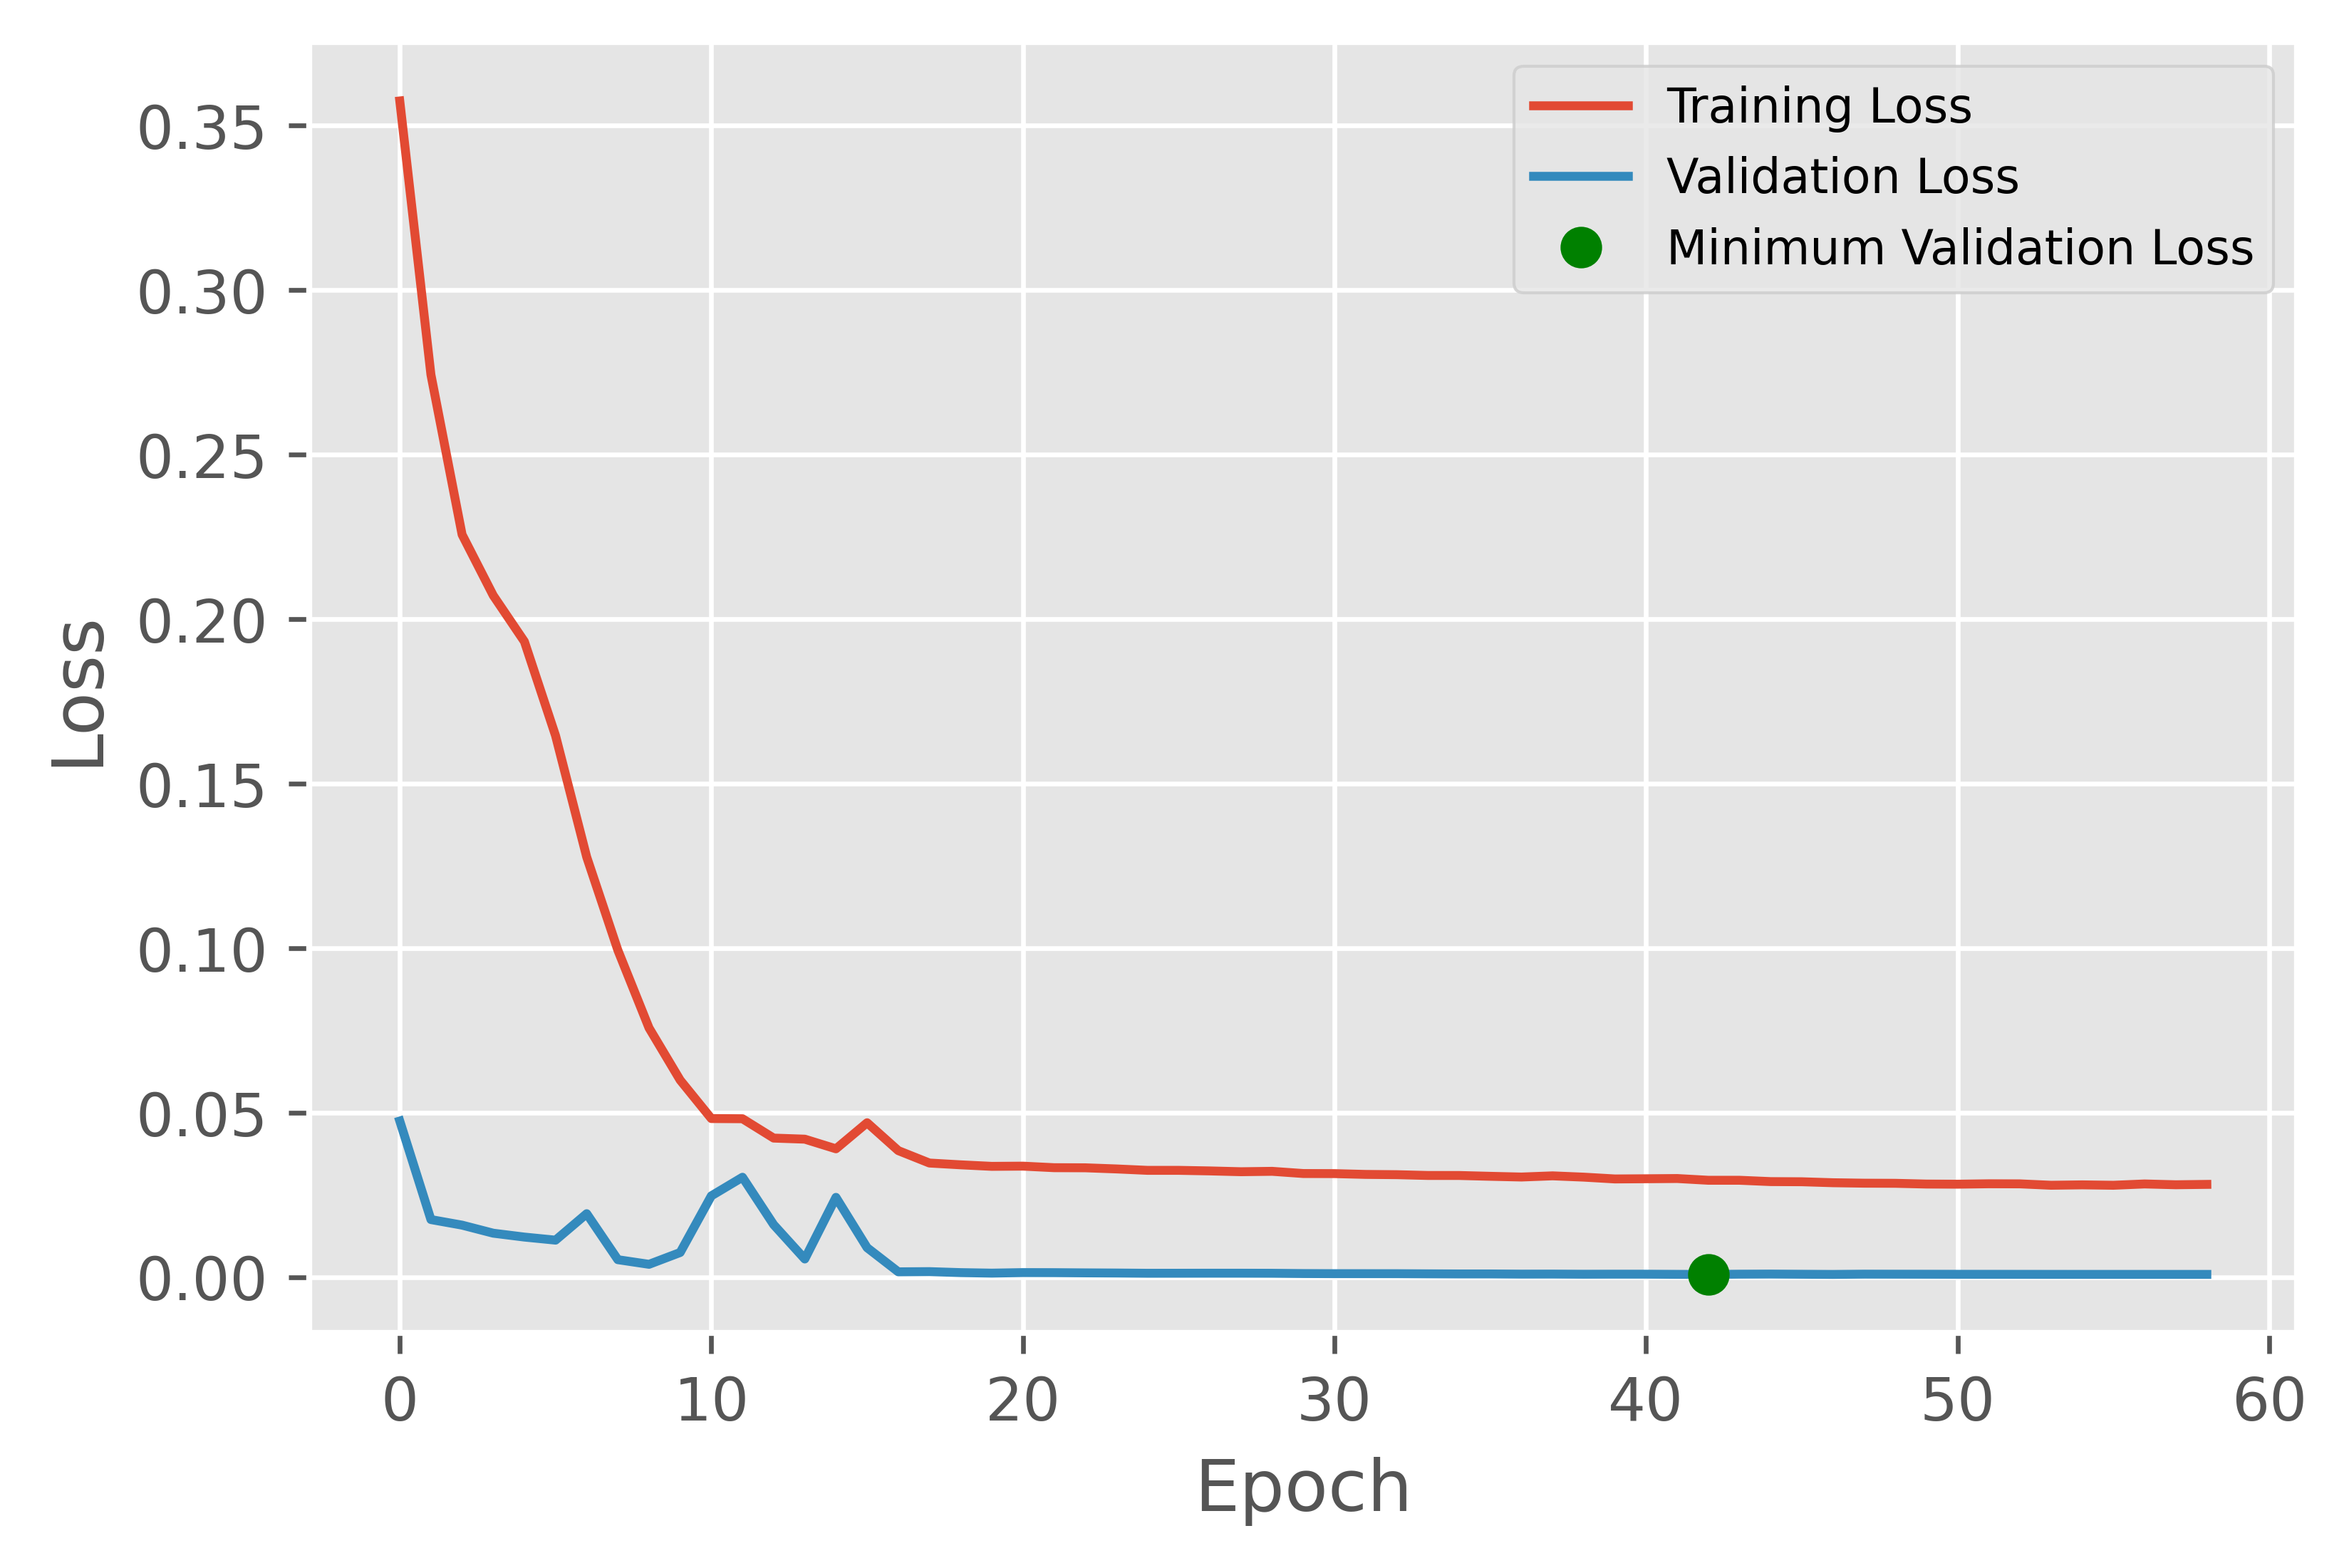

In [ ]:
TSS_Epoch_Dict = Load("TSS_Epoch_Dict_100_S", "pkl", Path2)
TSS_Train_Loss_100_S = Load("TSS_Train_Loss_100_S", "npy", Path2)
TSS_Valid_Loss_100_S = Load("TSS_Valid_Loss_100_S", "npy", Path2)
Best_Epoch = TSS_Epoch_Dict["Best"]
Final_Epoch = TSS_Epoch_Dict["Final"]

num=np.arange(0, len(TSS_Train_Loss_100_S[:Final_Epoch+1]))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Train_Loss_100_S[:Final_Epoch+1], linewidth=1.5, label="Training Loss")
plt.plot(num, TSS_Valid_Loss_100_S[:Final_Epoch+1], linewidth=1.5, label="Validation Loss")
plt.plot(Best_Epoch, TSS_Valid_Loss_100_S[Best_Epoch], "go", linewidth=0.5, label="Minimum Validation Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
print("Best Epoch:", Best_Epoch+1)
print("Final Epoch:", Final_Epoch+1)
print("Training Loss:", TSS_Train_Loss_100_S[Best_Epoch])
print("Validation Loss:", TSS_Valid_Loss_100_S[Best_Epoch])

Best Epoch: 43
Final Epoch: 59
Training Loss: 0.02946287777191719
Validation Loss: 0.0008315659360960126


## Model Evaluation

In [ ]:
# set target and its index
target = 'TSS_out'
target_index = Return_Column_Position(data, "TSS_out")

# set parameters
input_size = data.shape[1]
output_size = 1
val_ratio = 0.1
test_ratio = 0.2

best_comb_TSS = Load("Best_Comb_TSS", "pkl", Path2)
Sequence_Length = best_comb_TSS['sequence_length']
Num_Filter = best_comb_TSS['num_filters']
Conv_Kernel_Size = best_comb_TSS['conv1_kernel_size']
Layers = best_comb_TSS['num_lstm_layers']
Hidden_Size = best_comb_TSS['num_lstm_hiddens']
Batch_Size = best_comb_TSS['batch_sizes']

# separating dataframes
train_df, val_df, train_val_df, test_df = train_val_test(data, val_ratio, test_ratio, Sequence_Length)

# scaling data into -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_val_df)
test_df = df_scaler(test_df, scaler)

# making sequences
test_sequences = Sequence_Maker(test_df, target, Sequence_Length)

# making datasets
test_dataset = Dataset(test_sequences)

# making dataloaders
test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_Size, shuffle=False, num_workers=1)

best_scaler_TSS = Load("Best_Scaler_TSS", "pkl", Path2)

target_index = Return_Column_Position(data, "TSS_out")

model = Load("Best_Model_TSS_Retrained_100_S", "pkl", Path2)

# making predictions of testset

predictions_list = []
labels_list = []

model.eval()

print("Testing ...")
for item in tqdm(test_loader):
    test_features = item["sequence"]
    test_labels = item["label"]

    test_output = model(test_features)

    for i in range(len(test_labels)):
        predictions_list.append(test_output[i].item())
        labels_list.append(test_labels[i].item())


# descaling labels and predictions

descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = best_scaler_TSS.min_[target_index], best_scaler_TSS.scale_[target_index]

TSS_predictions = descale(descaler, predictions_list)
TSS_true_labels = descale(descaler, labels_list)


# evaluation

Evaluate(TSS_true_labels, TSS_predictions)

# Evaluate(labels_list, predictions_list)
# AR2(input_size, len(labels_list), labels_list, predictions_list)

Testing ...


  0%|          | 0/4 [00:00<?, ?it/s]

---------- Evaluation Results ----------

RMSE is:   8.849
MAE is:   6.641
MAPE is:   0.231
R-squared is:   0.568


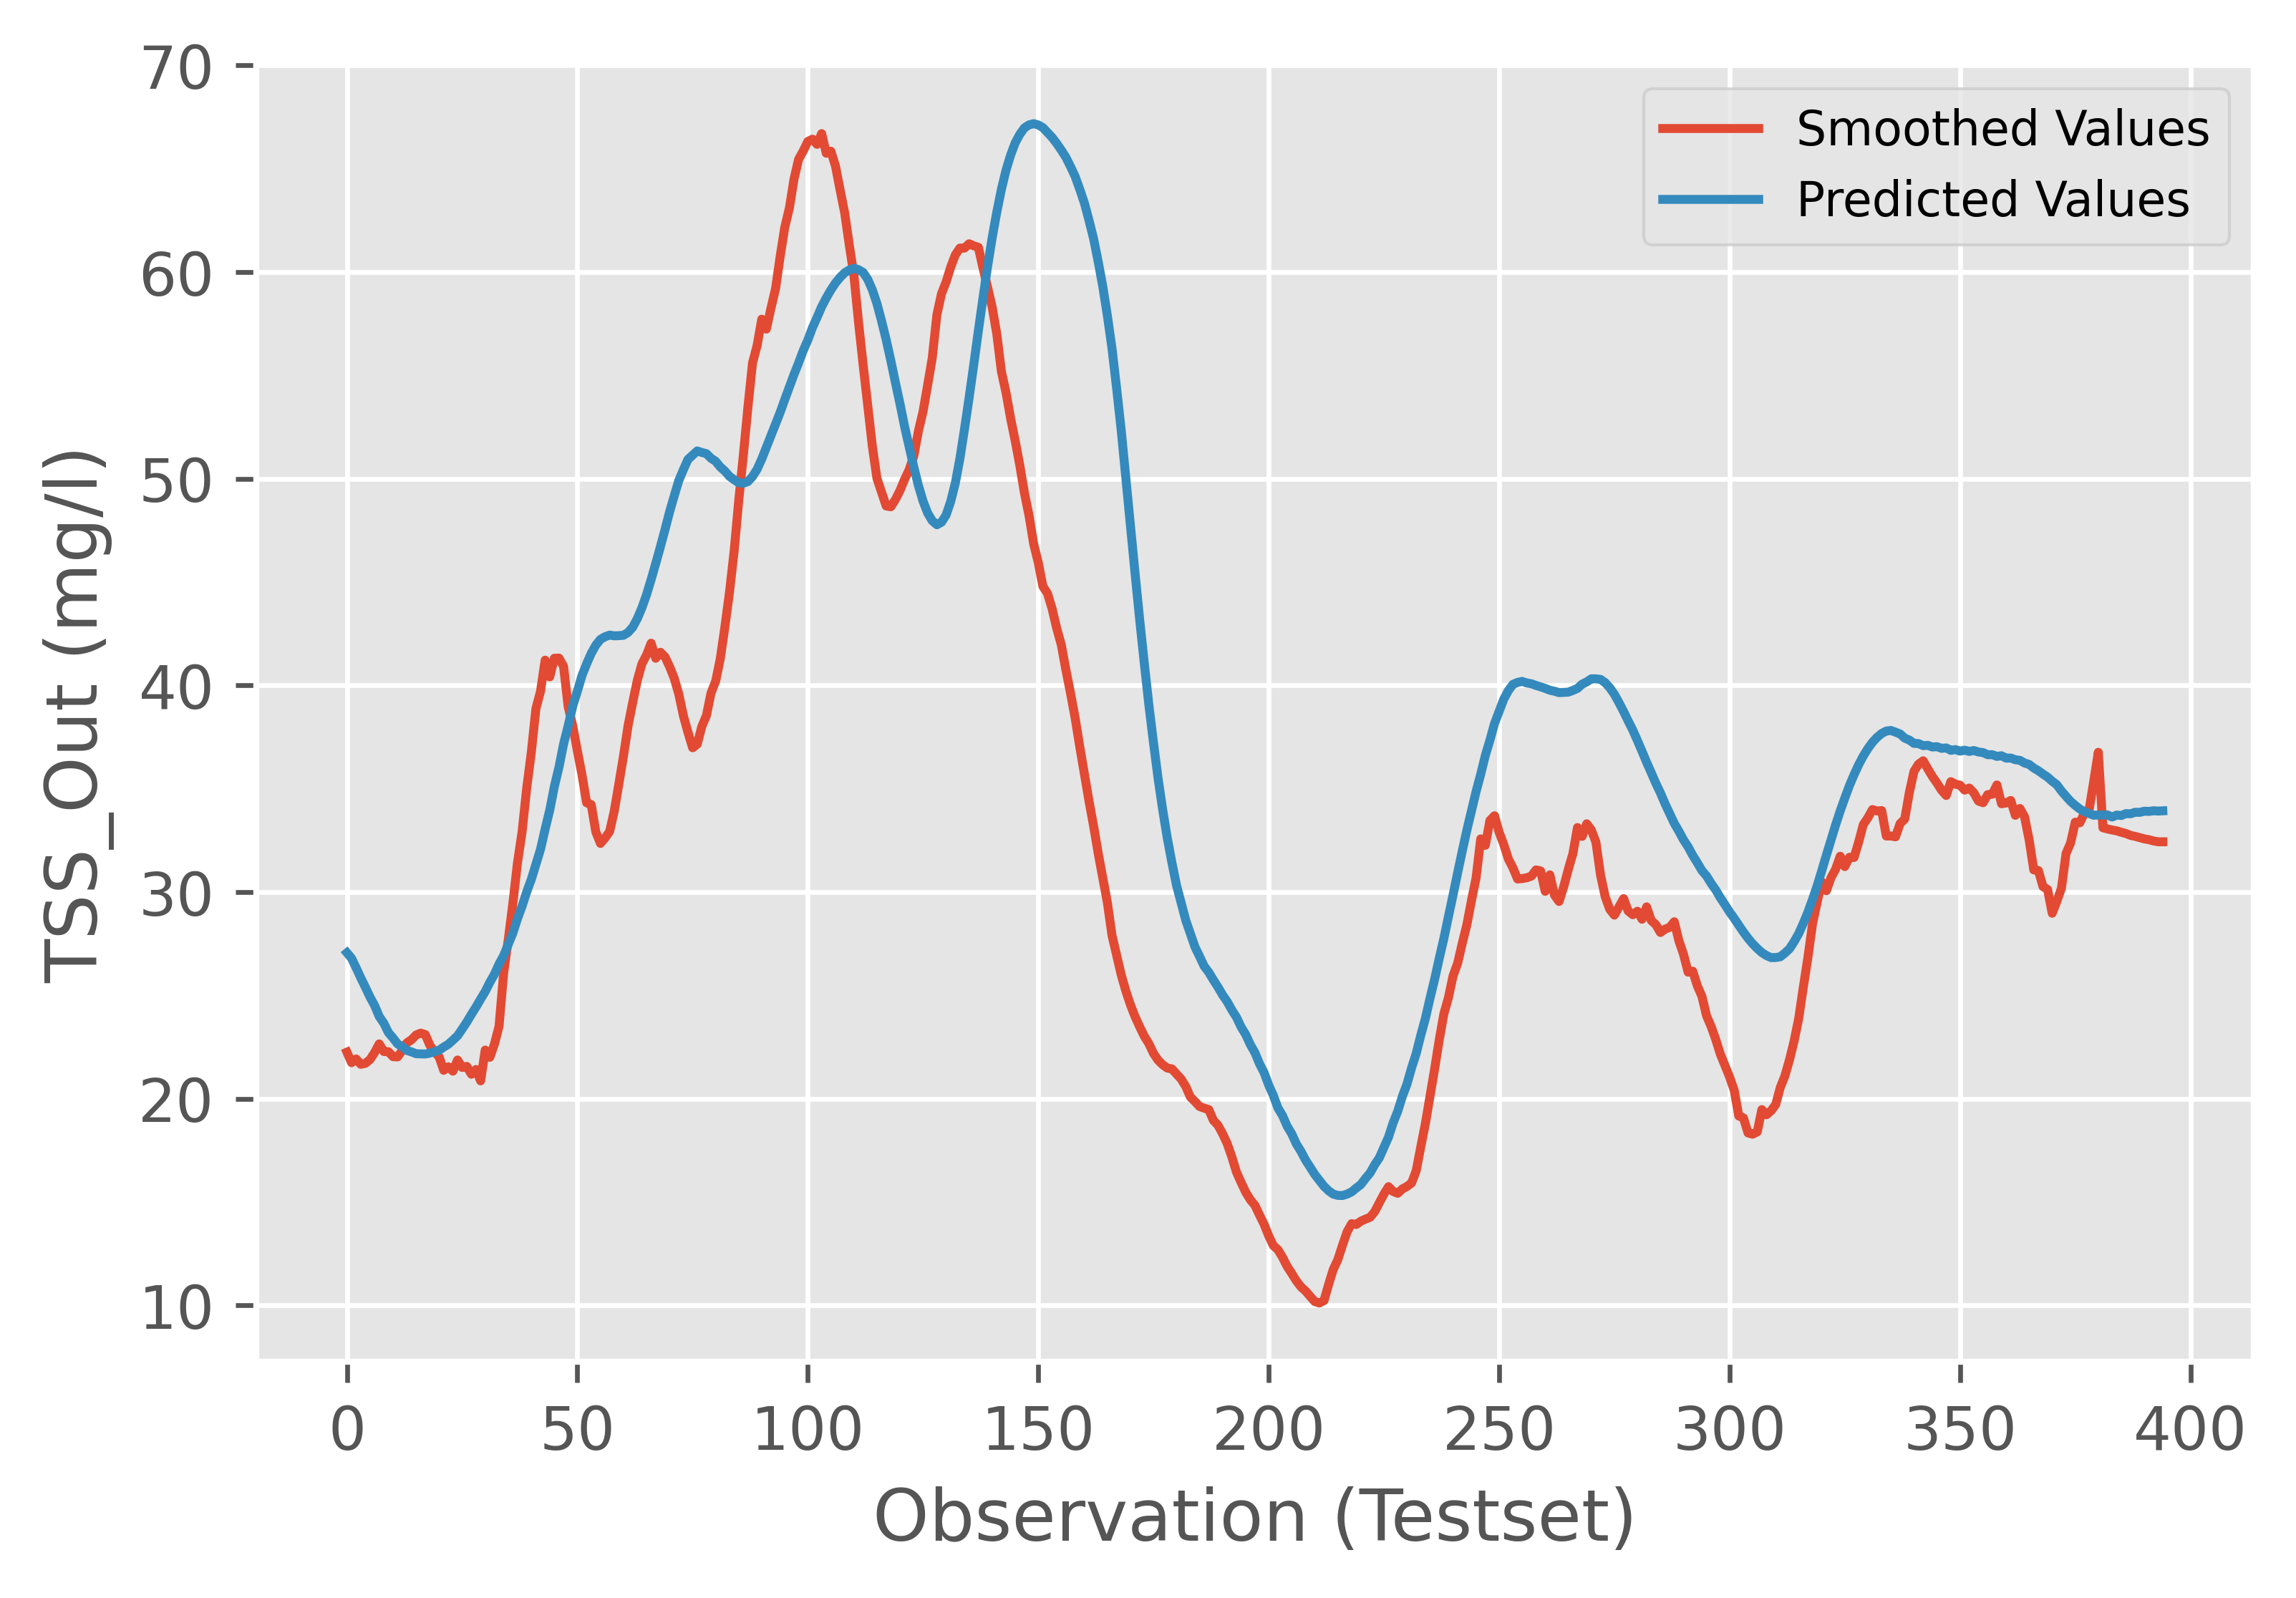

In [ ]:
num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_true_labels, linewidth=1.5, label="Smoothed Values")
plt.plot(num, TSS_predictions, linewidth=1.5, label="Predicted Values")
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("TSS_Out (mg/l)", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()

In [ ]:
df2 = Load("Preprocessed Data (Unsmoothed) - New", "xlsx", Dir=Path1)

TSS_Real = df2.loc[:, "TSS_out"].to_numpy()
TSS_Real_Test = TSS_Real[-len(TSS_predictions):]

Evaluate(TSS_Real_Test, TSS_predictions)

---------- Evaluation Results ----------

RMSE is:   15.465
MAE is:   12.449
MAPE is:   0.747
R-squared is:   0.381


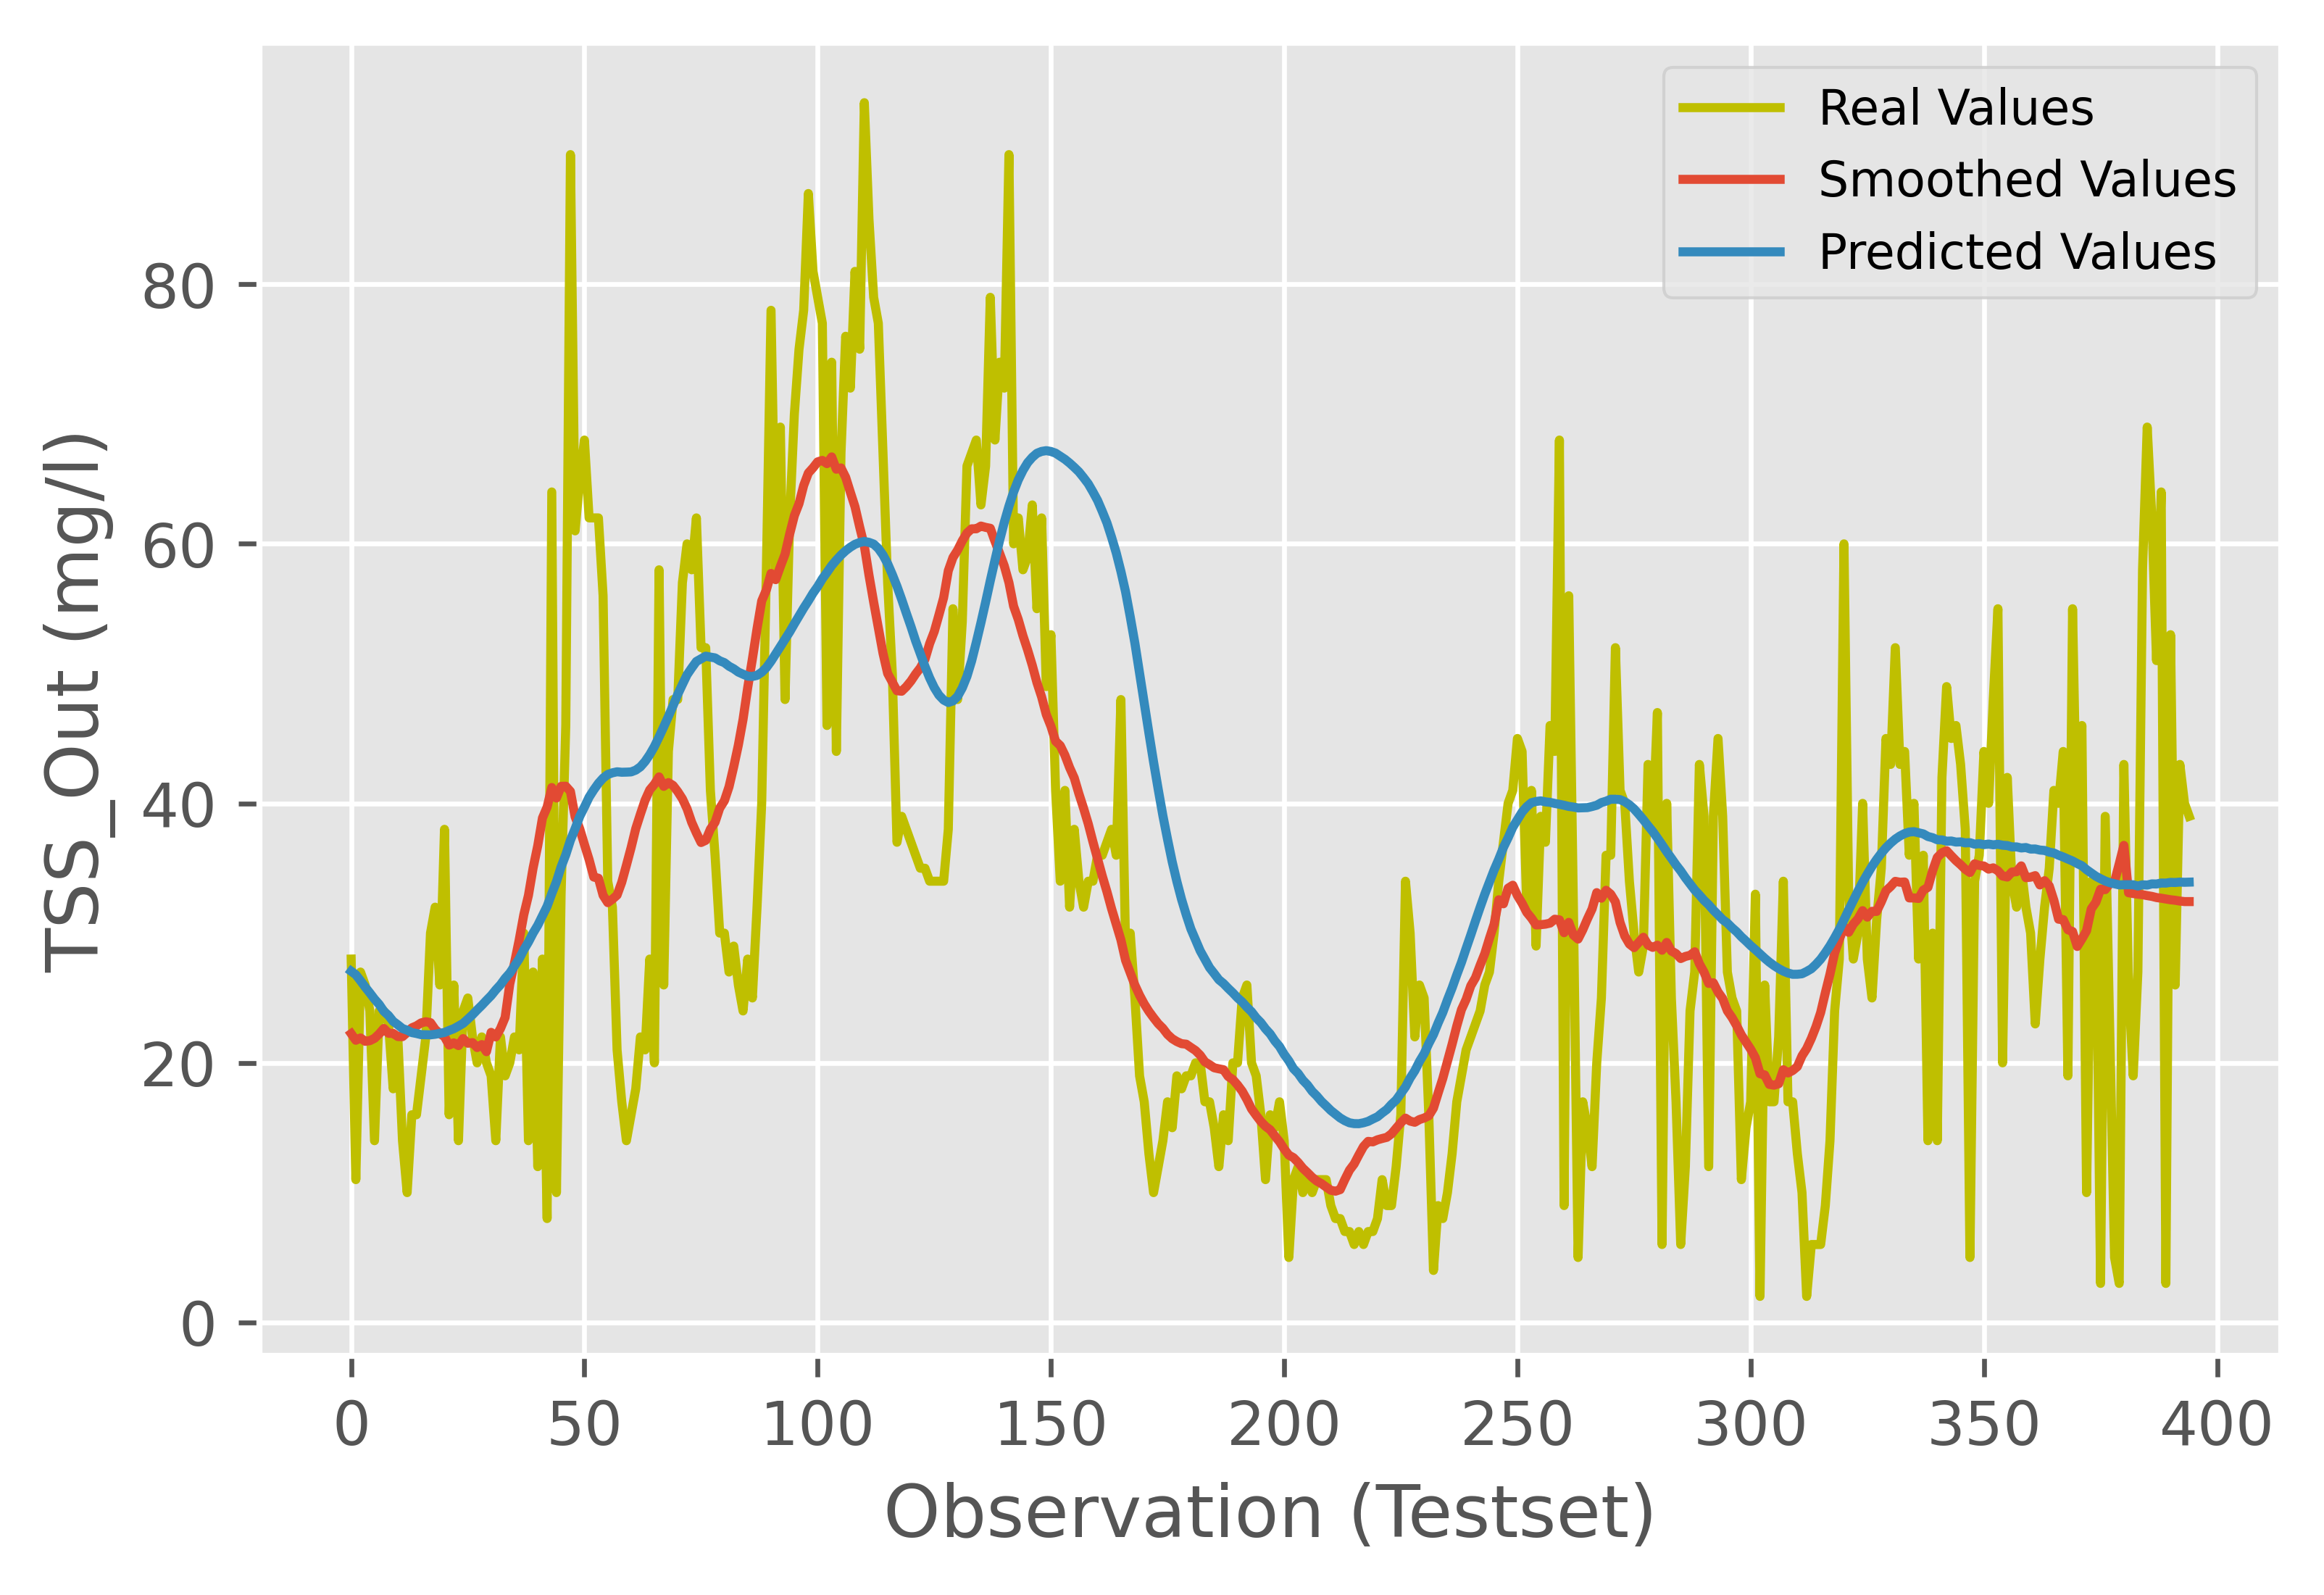

In [ ]:
num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Real_Test, linewidth=1.5, color='y', label="Real Values")
plt.plot(num, TSS_true_labels, linewidth=1.5, label="Smoothed Values")
plt.plot(num, TSS_predictions, linewidth=1.5, label="Predicted Values")
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("TSS_Out (mg/l)", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()

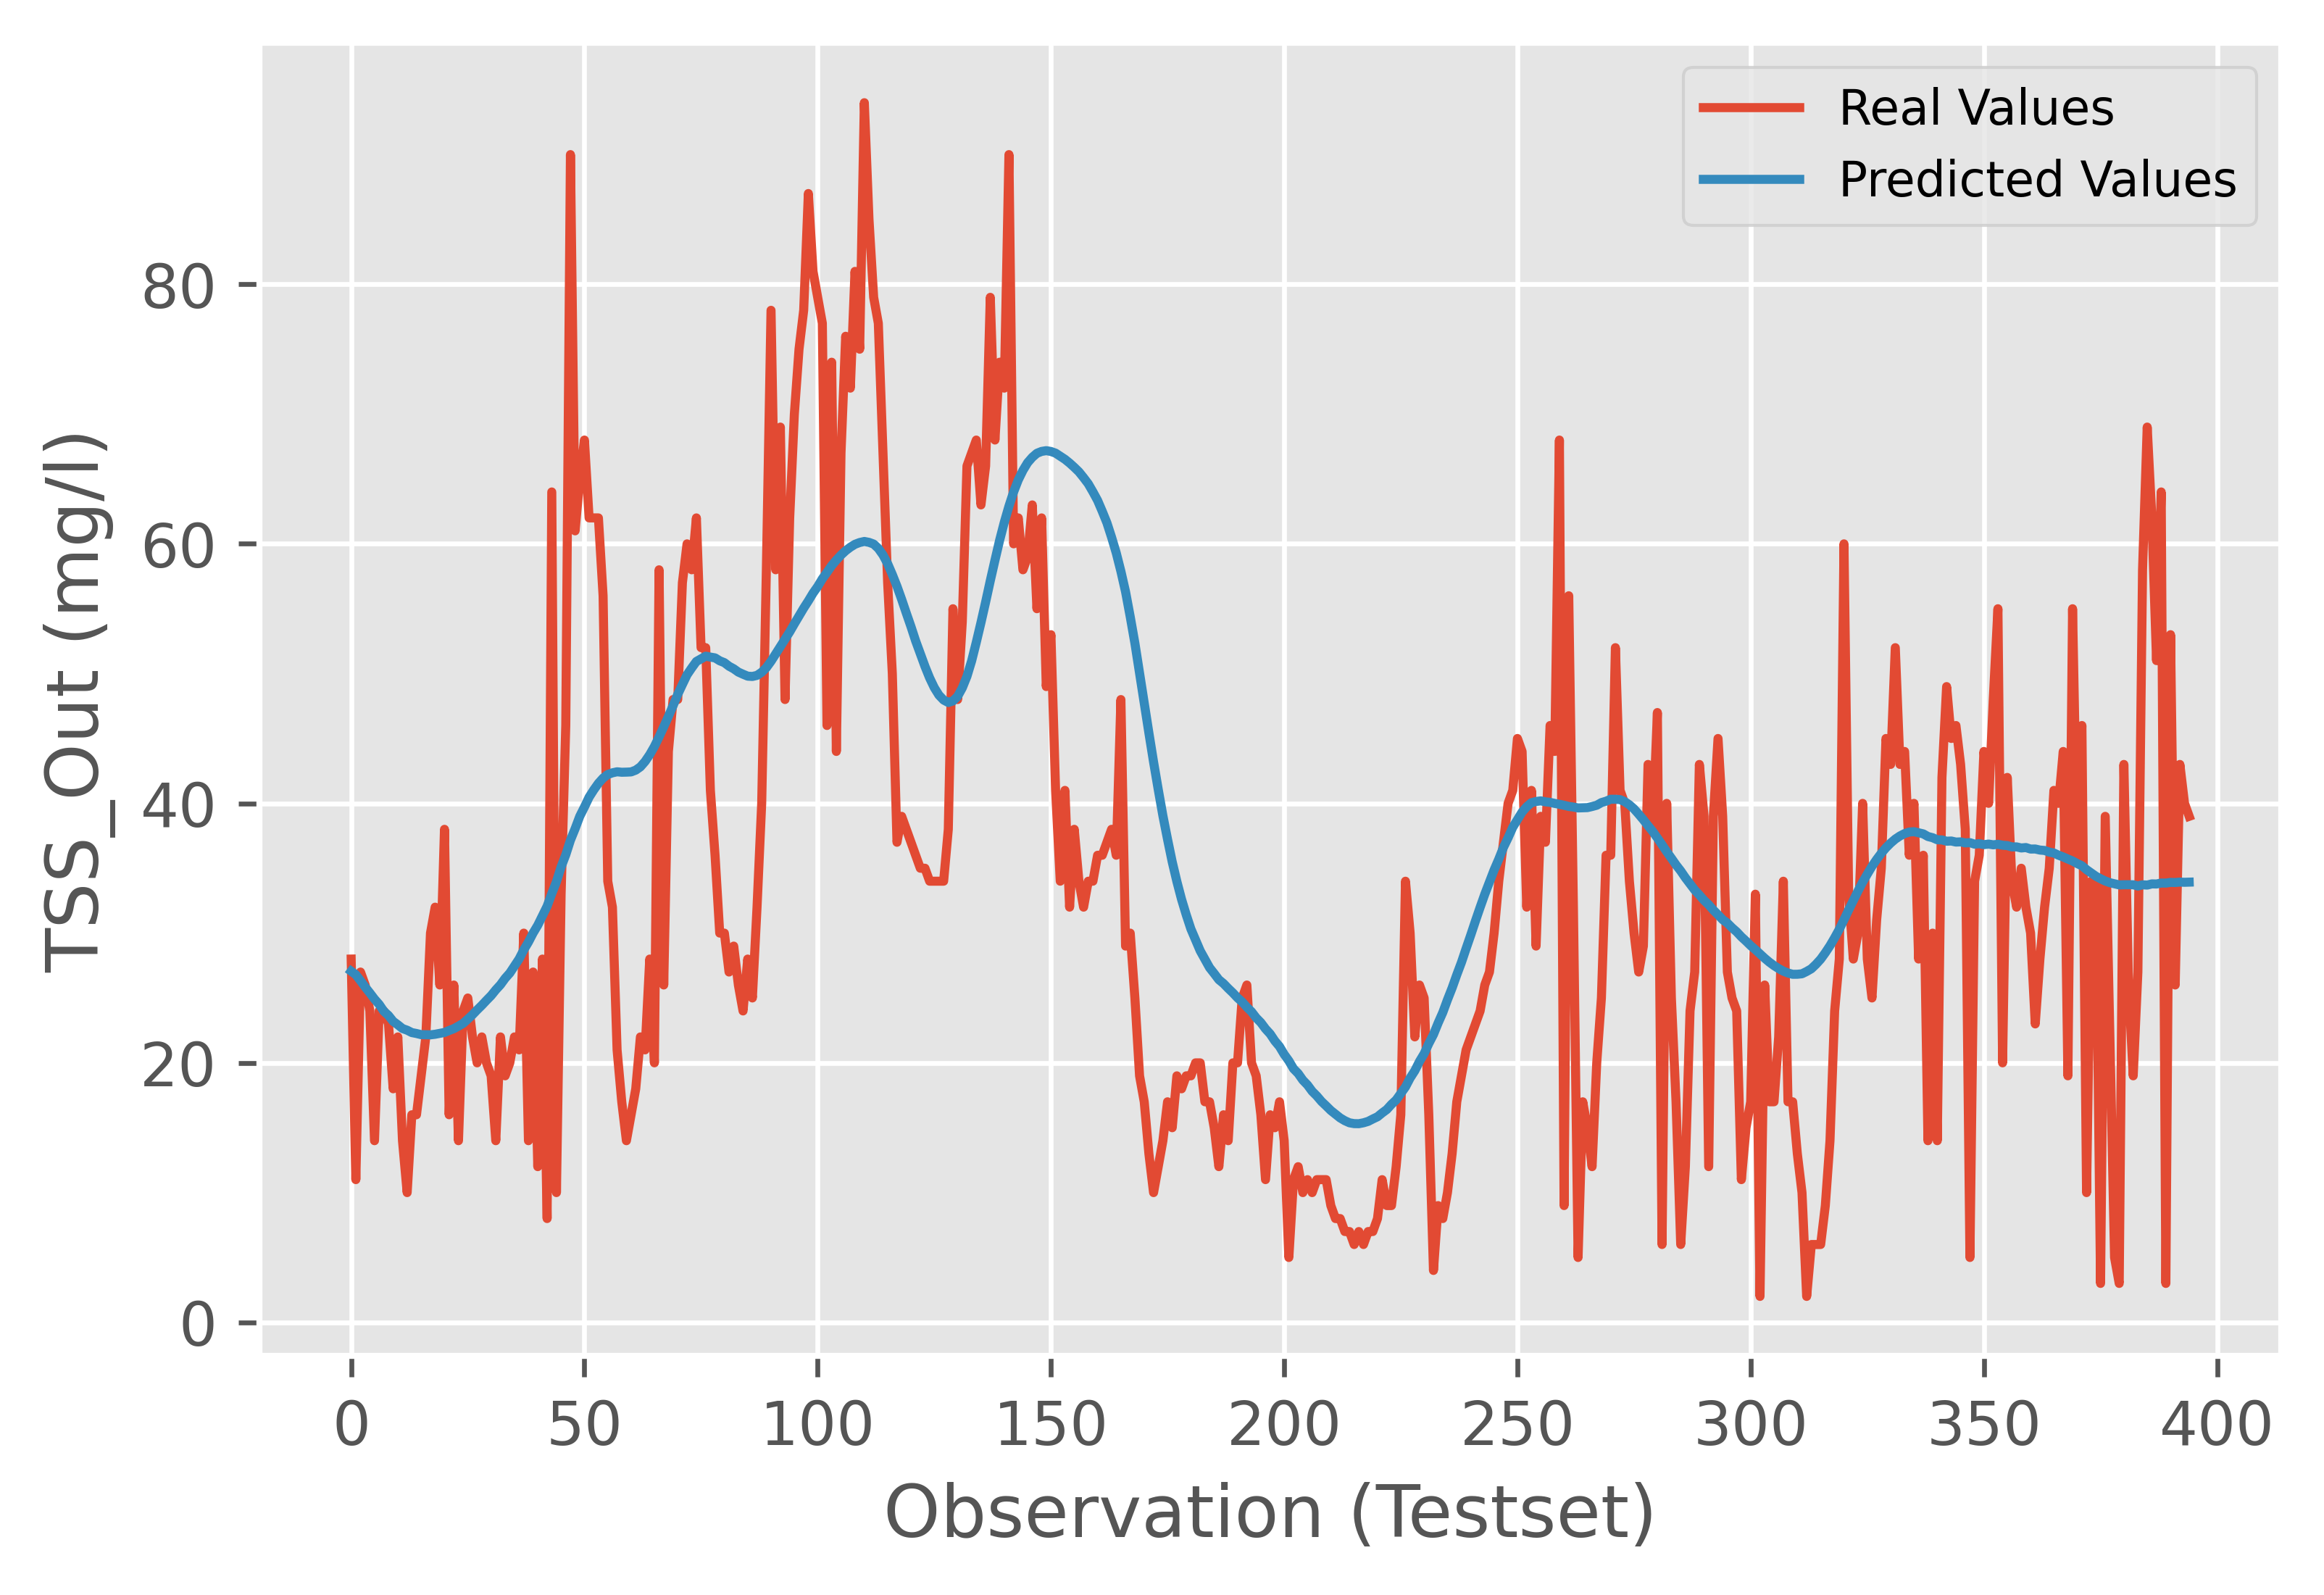

In [ ]:
num=np.arange(0, len(TSS_predictions))
plt.figure(dpi=600)
# plt.style.use('default')
plt.style.use('ggplot')
plt.plot(num, TSS_Real_Test, linewidth=1.5, label="Real Values")
plt.plot(num, TSS_predictions, linewidth=1.5, label="Predicted Values")
plt.xlabel("Observation (Testset)", fontsize=12)
plt.ylabel("TSS_Out (mg/l)", fontsize=12)
plt.legend(prop={'size': 8})
plt.show()